In [1]:
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random


# Load the dataset
dataset = load_dataset('bigscience/P3', 'cos_e_v1.11_aligned_with_common_sense')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_projected = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    "Generate a flowchart to visually represent the logic needed to answer the question",
    "Write pseudocode for an algorithm that could determine the answer", 
    "Imagine you are explaining the answer to a 5-year-old. Use simple words and analogies.",
    "Summarize the key insights needed to answer in a short poem",
    "Draw a concept map connecting all ideas relevant to the question",
    "List assumptions you must make to provide an answer. What if those assumptions were different?",
    "Compare and contrast multiple ways to approach the question", 
    "Translate the essence of the question into visual art and describe your interpretation",
    "Act out an exaggerated skit to depict the logic behind the answer",
    "Design a decision tree leading to the final answer",
    "Develop a graphic organizer highlighting relationships between key ideas",
    "Frame the question from different philosophical perspectives and give each perspective's answer", 
    "Outline an experiment that could empirically validate the answer",
    "Write a song conveying the concepts needed to respond accurately",
    "Create a metaphor relating the question to a seemingly unrelated domain",
    "Prototype a computer program to compute the answer algorithmically"
]

print(f'tokenizing prompts')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

def tokenize_function(example):
    return tokenizer(example['inputs_pretokenized'], truncation=True, padding='max_length')

# Apply the function to the dataset
print('tokenzing dataset')
dataset = dataset.map(tokenize_function, batched=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension and batch dimension
        return x.squeeze(1).mean(dim=0)


# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = AdamW(learn_weights.parameters())

# Training parameters
epochs = 5
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ppxscal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenizing prompts
prompt list length 16
tokenzing dataset


/home/ppxscal/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
Epoch 1/20, Batch 0/9741
Batch Indices: [6680, 6681]
Loss: 8.764453887939453
Weights for this question: tensor([ 0.1527, -0.0662,  0.0923, -0.0372, -0.0458,  0.0440, -0.0061, -0.0677,
        -0.0254, -0.0676, -0.1059,  0.0018, -0.0907,  0.0411, -0.0492,  0.0295],
       device='cuda:0', grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: With all the leaves falling each year, a natural compost keeps the soil healthy for all the trees where?\nPossible A: garden, useful for recycling, surface of earth, forest, orchard\n\nWhy is "forest" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: With elderly resident, Illness is a common way a stay ends where?\nPossible A: hospital, sick person, grave yard, nursing home, brain\n\nWhy is "nursing home" an answer aligned with human common sense? \n']

Epoch 1/20, Batch 200/9741
Batch Indices: [9862, 9863]
Loss: 6.919430255889893
Weights for this 

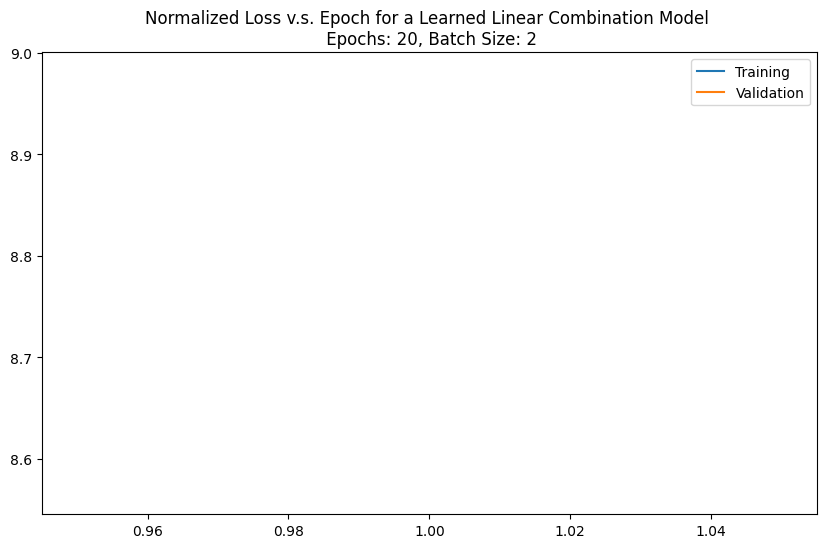

Epoch 2/20, Batch 0/9741
Batch Indices: [15654, 15655]
Loss: 8.70276927947998
Weights for this question: tensor([-0.2591, 14.0068, -2.3312,  0.1884, -0.5426, -9.0626,  8.0275, -1.2030,
        -0.9412,  2.2466,  1.6728,  5.4878,  1.0926,  7.1362, 11.9646,  9.2820],
       device='cuda:0', grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: Where can someone view a county highway as a line?\nPossible A: from the sky, map, cross counties by car, country, michigan\n\nWhy is "map" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: Where can someone watch a show from a balcony?\nPossible A: theater, opera house, concert, new orleans, michigan\n\nWhy is "theater" an answer aligned with human common sense? \n']

Epoch 2/20, Batch 200/9741
Batch Indices: [10846, 10847]
Loss: 6.871683597564697
Weights for this question: tensor([-0.5737, 14.5733, -2.2553,  0.3974, -0.3037, -9.2511,  8.4267, -1.3482,
      

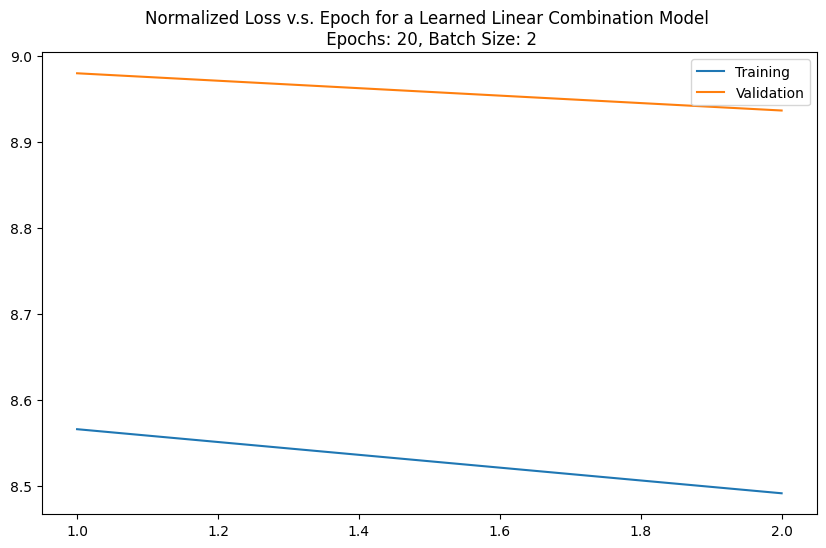

Epoch 3/20, Batch 0/9741
Batch Indices: [7826, 7827]
Loss: 8.029094696044922
Weights for this question: tensor([-102.9360,   16.6949,  -65.8840,  -11.9611,  -26.8849,  -43.4775,
          26.2821,  -98.1576,  -91.8820,  -39.3018,  -42.9932,  -72.9451,
         -65.4779,    3.1257,    6.2905,  -25.4056], device='cuda:0',
       grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: His saw was too big to fit with all his wrenches and screwdrivers in his metal what?\nPossible A: toolbox, cabinet, basement, tool shed, tool kit\n\nWhy is "toolbox" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: Hitting what is likely to cause broken glass in a car?\nPossible A: field, bridge, bottom of sea, street, wall\n\nWhy is "bridge" an answer aligned with human common sense? \n']

Epoch 3/20, Batch 200/9741
Batch Indices: [2744, 2745]
Loss: 8.45130443572998
Weights for this question: tensor([-134.3999,    3.624

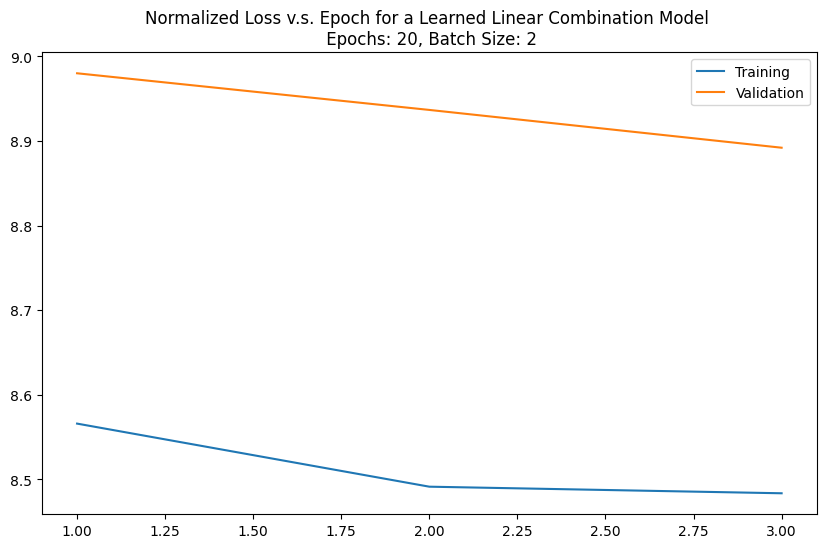

Epoch 4/20, Batch 0/9741
Batch Indices: [16622, 16623]
Loss: 6.25867223739624
Weights for this question: tensor([-200.9936,   59.8473, -135.3198,   66.1251,  -16.0659,  -55.2723,
           7.2555, -174.1785, -149.1931,  -82.8218,  -20.5109,  -13.2970,
         -55.0086,   15.2703,   81.0744,  -49.2482], device='cuda:0',
       grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: Where does a marmoset not usually go?\nPossible A: dictionary, wilderness, fly, underground, colorado\n\nWhy is "underground" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: Where does a marmoset roam free?\nPossible A: rainforest, kitchen, wilderness, dictionary, burrow\n\nWhy is "wilderness" an answer aligned with human common sense? \n']

Epoch 4/20, Batch 200/9741
Batch Indices: [7528, 7529]
Loss: 8.639772415161133
Weights for this question: tensor([-243.1847,   71.8306, -175.7899,   83.4290,  -22.7413,  -66.9134,


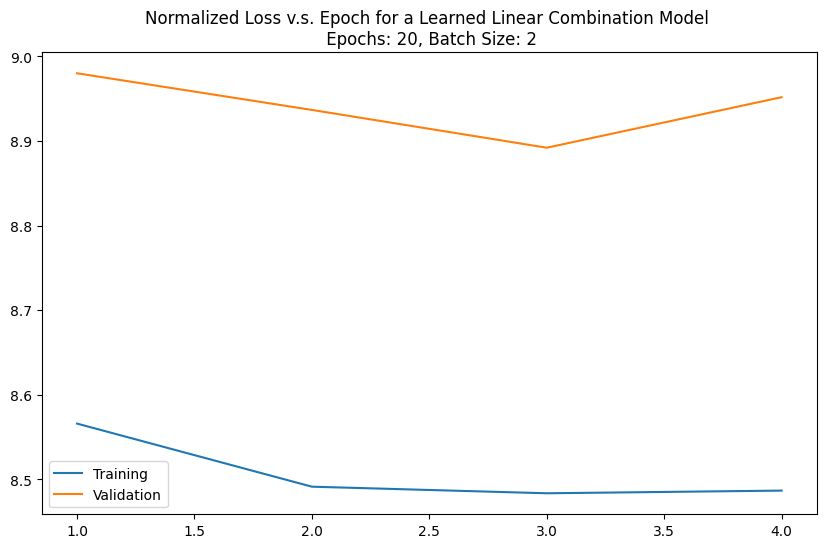

Epoch 5/20, Batch 0/9741
Batch Indices: [17086, 17087]
Loss: 8.202367782592773
Weights for this question: tensor([-175.1751,  126.3459, -136.7151,   18.4067,  -88.3953,   62.5548,
         160.3503,  -61.7350, -140.6576,   17.0265,   20.3688,  104.6409,
         -67.8584,   41.5817,  237.3311,   -7.4875], device='cuda:0',
       grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: Where is a traffic artery likely to be clogged?\nPossible A: high traffic area, major city, town, traffic lights, highway\n\nWhy is "major city" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: Where is a tree hugger likely to reside?\nPossible A: forest, rainforest, san francisco, state park, university\n\nWhy is "san francisco" an answer aligned with human common sense? \n']

Epoch 5/20, Batch 200/9741
Batch Indices: [12594, 12595]
Loss: 8.343153953552246
Weights for this question: tensor([-141.8280,  179.9958, -121.

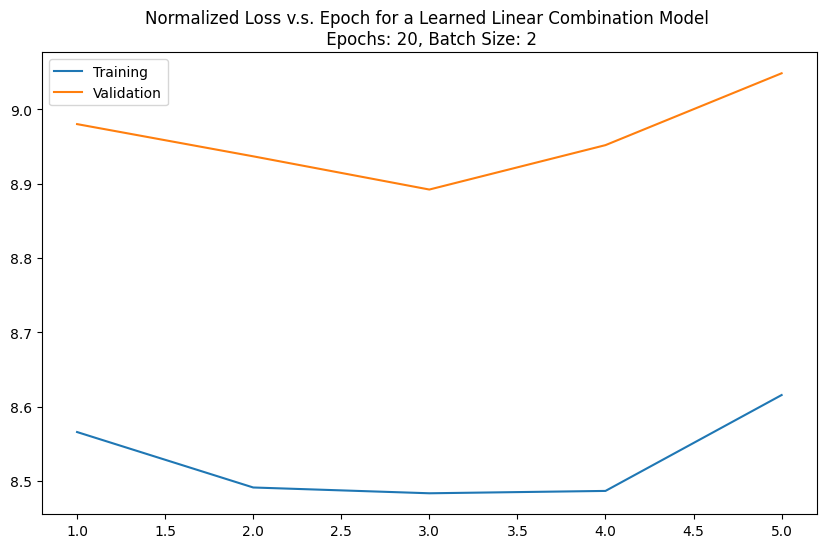

Epoch 6/20, Batch 0/9741
Batch Indices: [18788, 18789]
Loss: 9.259300231933594
Weights for this question: tensor([ -45.5322,  343.5875, -176.7935,  192.1055, -103.7454,  228.1567,
         213.2470,   52.6551,  -30.0038,   60.3378,   32.8489,  280.5505,
          27.1216,  109.8654,  411.2986,   83.3508], device='cuda:0',
       grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: Who can have the most influence on washington from a given county?\nPossible A: representative, cleverest, bitterest, alter, sweet\n\nWhy is "representative" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: Who collects many a drop of blood?\nPossible A: mosquito, human body, needle, slaughter house, blood bank\n\nWhy is "blood bank" an answer aligned with human common sense? \n']

Epoch 6/20, Batch 200/9741
Batch Indices: [9664, 9665]
Loss: 8.814828872680664
Weights for this question: tensor([ -44.4791,  339.8911, -17

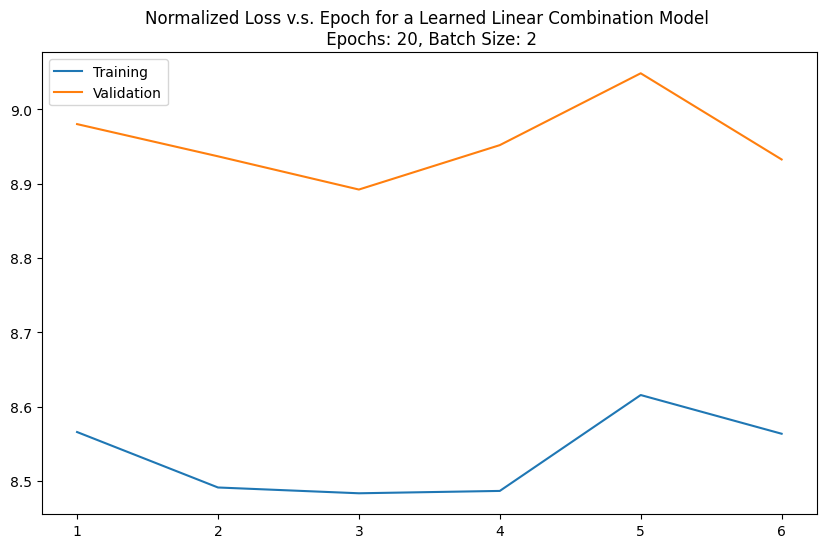

Epoch 7/20, Batch 0/9741
Batch Indices: [166, 167]
Loss: 7.311918258666992
Weights for this question: tensor([-706.4767,  293.7305, -500.8762,  407.5078,  -42.1172,   13.3321,
         118.4815, -724.3242, -422.6776,  -49.0745,  -44.0874,  -10.0100,
        -111.0628,  343.3256,  851.9024, -109.2275], device='cuda:0',
       grad_fn=<MeanBackward1>) question: ['Here\'s a question and a few possible answers: \n\nQ: A person met me in the lobby of the office.  We didn\'t have much in common, but we did something before going up to the meeting.  What did we do?\nPossible A: cross street, say love, shake hands, converse, sit up\n\nWhy is "converse" an answer aligned with human common sense? \n', 'Here\'s a question and a few possible answers: \n\nQ: A person might have their right-hand man, they could also be referred to as what digit?\nPossible A: wellness, number 1, own home, headache, 100\n\nWhy is "number 1" an answer aligned with human common sense? \n']

Epoch 7/20, Batch 200/9741
Ba

KeyboardInterrupt: 

In [2]:
# Training parameters
epochs = 20
batch_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Training...')

# Training loop
projected_losses = []
validation_losses = []

shapes = []


for epoch in range(epochs):
    epoch_loss_projected = 0
    epoch_loss_validation = 0
    for _ in range(0, len(train_dataset), batch_size):
        i = random.randint(0, len(train_dataset) - batch_size + 1 )
        batch = train_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)


        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')


        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)

        # Pass the combined embeddings through the model
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)
 

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()
        

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        if _ % 200 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Batch {_}/{len(train_dataset)}')
          print(f'Batch Indices: {[i + k for k in range(i, i+batch_size)]}')
          print(f'Loss: {loss_projected.item()}')
          print(f'Weights for this question: {weights} question: {batch["inputs_pretokenized"]}')
          print()

    print('Validating Epoch...')

    for _ in range(0, len(validation_dataset), batch_size):
        i = random.randint(0, len(validation_dataset) - batch_size + 1 )
        batch = validation_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)

        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')

        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_validation = outputs_projected.loss
        epoch_loss_validation += loss_validation.item()

    epoch_loss_projected /= (len(list(range(0, len(train_dataset), batch_size))))
    epoch_loss_validation /= (len(list(range(0, len(validation_dataset), batch_size))) - 1)

    print(f'Epoch Validation Loss: {epoch_loss_validation} \n', end='')
    print()

    projected_losses.append(epoch_loss_projected)
    validation_losses.append(epoch_loss_validation)

    # Create a DataFrame with the loss values
    n = len(projected_losses)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n + 1), projected_losses, label='Training')
    plt.plot(range(1, n + 1), validation_losses, label='Validation')
    
    plt.title(f'Normalized Loss v.s. Epoch for a Learned Linear Combination Model \n Epochs: {epochs}, Batch Size: {batch_size}')
    plt.legend()

    # Save the plot as a png file
    print(f'Saveing figure...')
    plt.savefig(f'loss_plot_epoch_{epoch+1}.png')
    plt.show()
